In [4]:
#!pip install control
#!pip install slycot

In [1]:
# importa os modulo necessários 

import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import control as ct


# 1 Modelagem pelo módulo Sympy

In [22]:
# Definindo as variáveis simbólicas

# Constantes
M, m1, m2, m3, l1, l2,J1, J2, g, t, f0, f1, f2 = sym.symbols('M m1 m2 m3 l1 l2 J1 J2 g t  f0 f1 f2')

# Variáveis
phi1, phi2, x,u ,theta1, theta2 = sym.symbols(r'phi1 phi2 x u theta1 theta2', cls=sym.Function) # funções para se trabalhar em cima


In [23]:
# Definindo as derivadas no tempo 

x = x(t)
u = u(t)
phi1 = phi1(t)
phi2 = phi2(t)
theta1 = theta1(t)
theta2 = theta2(t)

x_d = sym.diff(x, t)
phi1_d = sym.diff(phi1, t)
phi2_d = sym.diff(phi2, t)

x_dd = sym.diff(x_d, t)
phi1_dd = sym.diff(phi1_d, t)
phi2_dd = sym.diff(phi2_d, t)

dpdp2=phi2_d*phi2_d
dpdp1=phi1_d*phi1_d
dxdx=x_d*x_d

In [24]:
# Equação de Lagrange: L = T-U

L= 1/2* dxdx*(M+m1+m2)+1/2*dpdp1*(l1*l1*(m1+2*m2)+J1)+dpdp2*(m2*l2*l2+1/2*J2)+\
x_d*(-m1*l1*sym.cos(phi1)*phi1_d-2*m2*l1*sym.cos(phi1)*phi1_d-m2*l2*sym.cos(phi2)*phi2_d)+\
    phi1_d*(2*m2*l1*l2*phi2_d*sym.cos(phi1-phi2))-m1*l1*g*sym.cos(phi1)-m2*g*(2*l1*sym.cos(phi1)-l2*sym.cos(phi2))
L

-g*l1*m1*cos(phi1(t)) - g*m2*(2*l1*cos(phi1(t)) - l2*cos(phi2(t))) + 2*l1*l2*m2*cos(phi1(t) - phi2(t))*Derivative(phi1(t), t)*Derivative(phi2(t), t) + 0.5*(J1 + l1**2*(m1 + 2*m2))*Derivative(phi1(t), t)**2 + (0.5*J2 + l2**2*m2)*Derivative(phi2(t), t)**2 + 0.5*(M + m1 + m2)*Derivative(x(t), t)**2 + (-l1*m1*cos(phi1(t))*Derivative(phi1(t), t) - 2*l1*m2*cos(phi1(t))*Derivative(phi1(t), t) - l2*m2*cos(phi2(t))*Derivative(phi2(t), t))*Derivative(x(t), t)

In [25]:
# Euler Lagrange-equation
eqnx = sym.diff(sym.diff(L,x_d),t)-sym.diff(L,x)-u+f0*x_d
eqn_phi1 = sym.diff(sym.diff(L,phi1_d),t)-sym.diff(L,phi1)+(f1+f2)*phi1_d -f2*phi2_d
eqn_phi2 = sym.diff(sym.diff(L,phi2_d),t)-sym.diff(L,phi2)-f2*phi1_d + f2*phi2_d

# Solução 

sol_xdd = sym.solve(eqnx, x_dd)[0]
sol_phi1dd = sym.solve(eqn_phi1, phi1_dd)[0]
sol_phi2dd = sym.solve(eqn_phi2, phi2_dd)[0]

In [26]:
q_dd = sym.Matrix([(x_dd,phi1_dd,phi2_dd)])
q_d = sym.Matrix([(x_d,phi1_d,phi2_d)])

ponto_eq = {x:0,x_d:0,x_dd:0,phi1:0,phi2:0,phi1_d:0,phi2_d:0,phi2_dd:0,phi1_dd:0,sym.cos(phi1):1,\
            sym.cos(phi2):1,sym.cos(phi1-phi2):1,sym.sin(phi1):theta1,sym.sin(phi2):theta2}


In [27]:

H = sym.Matrix((sym.diff(eqnx,q_dd),sym.diff(eqn_phi1,q_dd),sym.diff(eqn_phi2,q_dd))).subs(ponto_eq)

H_inv = H.inv()
H

Matrix([
[1.0*M + 1.0*m1 + 1.0*m2,               -l1*m1 - 2*l1*m2,          -l2*m2],
[       -l1*m1 - 2*l1*m2, 1.0*J1 + 1.0*l1**2*(m1 + 2*m2),      2*l1*l2*m2],
[                 -l2*m2,                     2*l1*l2*m2, J2 + 2*l2**2*m2]])

In [28]:
N = sym.Matrix((sym.diff(eqnx,q_d),sym.diff(eqn_phi1,q_d),sym.diff(eqn_phi2,q_d))).subs(ponto_eq)
N

Matrix([
[f0,       0,   0],
[ 0, f1 + f2, -f2],
[ 0,     -f2,  f2]])

In [29]:
W = sym.Matrix([0,g*l1*sym.sin(phi1)*(m1+2*m2),-g*m2*l2*sym.sin(phi2)]).subs(ponto_eq)
W

Matrix([
[                         0],
[g*l1*(m1 + 2*m2)*theta1(t)],
[        -g*l2*m2*theta2(t)]])

In [30]:
V = sym.Matrix([u,0,0])
V

Matrix([
[u(t)],
[   0],
[   0]])

In [31]:
C = N*q_d.transpose() + W
S = (-H_inv*C).subs(ponto_eq)
S

Matrix([
[          -g*l1*(m1 + 2*m2)*(-1.0*J2*l1*m1 - 2.0*J2*l1*m2 - 2.0*l1*l2**2*m1*m2 - 2.0*l1*l2**2*m2**2)*theta1(t)/(-1.0*J1*J2*M - 1.0*J1*J2*m1 - 1.0*J1*J2*m2 - 2.0*J1*M*l2**2*m2 - 2.0*J1*l2**2*m1*m2 - 1.0*J1*l2**2*m2**2 - 1.0*J2*M*l1**2*m1 - 2.0*J2*M*l1**2*m2 + 1.0*J2*l1**2*m1*m2 + 2.0*J2*l1**2*m2**2 - 2.0*M*l1**2*l2**2*m1*m2 + 3.0*l1**2*l2**2*m1*m2**2 + 2.0*l1**2*l2**2*m2**3) + g*l2*m2*(-1.0*J1*l2*m2 + 1.0*l1**2*l2*m1*m2 + 2.0*l1**2*l2*m2**2)*theta2(t)/(-1.0*J1*J2*M - 1.0*J1*J2*m1 - 1.0*J1*J2*m2 - 2.0*J1*M*l2**2*m2 - 2.0*J1*l2**2*m1*m2 - 1.0*J1*l2**2*m2**2 - 1.0*J2*M*l1**2*m1 - 2.0*J2*M*l1**2*m2 + 1.0*J2*l1**2*m1*m2 + 2.0*J2*l1**2*m2**2 - 2.0*M*l1**2*l2**2*m1*m2 + 3.0*l1**2*l2**2*m1*m2**2 + 2.0*l1**2*l2**2*m2**3)],
[                 -g*l1*(m1 + 2*m2)*(-1.0*J2*M - 1.0*J2*m1 - 1.0*J2*m2 - 2.0*M*l2**2*m2 - 2.0*l2**2*m1*m2 - 1.0*l2**2*m2**2)*theta1(t)/(-1.0*J1*J2*M - 1.0*J1*J2*m1 - 1.0*J1*J2*m2 - 2.0*J1*M*l2**2*m2 - 2.0*J1*l2**2*m1*m2 - 1.0*J1*l2**2*m2**2 - 1.0*J2*M*l1**2*m1 - 2.0*

In [32]:
B_0 = sym.Matrix([q_dd.transpose(),-H_inv*V])
B_0

Matrix([
[                                                                                                                                                                                                                                                                                                                                                  Derivative(x(t), (t, 2))],
[                                                                                                                                                                                                                                                                                                                                               Derivative(phi1(t), (t, 2))],
[                                                                                                                                                                                                                                                                  

In [33]:
f = sym.Matrix([q_dd.transpose(),S])
f

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Derivative(x(t), (t, 2))],
[                                                                                                                                                                                                                                                                          

In [34]:
q_a = sym.Matrix([x,theta1,theta2])
q = sym.Matrix([q_a,q_dd.transpose()])
q

Matrix([
[                       x(t)],
[                  theta1(t)],
[                  theta2(t)],
[   Derivative(x(t), (t, 2))],
[Derivative(phi1(t), (t, 2))],
[Derivative(phi2(t), (t, 2))]])

In [35]:
f_s = f.jacobian(q)
f_s

Matrix([
[0,                                                                                                                                                                                                                                                                                                                                                                                    0,                                                                                                                                                                                                                                                                                                                                                                                           0, 1, 0, 0],
[0,                                                                                                                                                                                                                           

In [36]:
valor_param = {M:1,m1:1,m2:1,J1:0.00083,J2:0.00083,\
               l1:0.05,l2:0.05,g:9.81,f0:0.01,f1:0.007,f2:0.007}

A_s = f_s.subs(valor_param)
A = np.matrix(A_s).astype(np.float64)
A

matrix([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
        [ 0.00000000e+00,  1.45673438e+02,  2.59311938e+01,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  3.49662904e+03,  5.83160281e+02,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -1.74948084e+03, -1.93609213e+02,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [37]:
# Matriz B
b_i = B_0.jacobian([u])
B_s = b_i.subs(valor_param)
B = np.matrix(B_s).astype(np.float64)
#b_i
B

matrix([[  0.        ],
        [  0.        ],
        [  0.        ],
        [  3.73538037],
        [ 98.99656009],
        [-52.86685795]])

In [18]:
C = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]])
#C = np.array([[1, 0, 0, 0, 0, 0]])
D = np.zeros((6,1))

# 2 Modelagem pelo módulo Numpy

# 3 Estabilidade

In [186]:
sys = ct.ss(A,B,C,D)
print(sys)

<LinearIOSystem>: sys[4]
Inputs (1): ['u[0]']
Outputs (6): ['y[0]', 'y[1]', 'y[2]', 'y[3]', 'y[4]', 'y[5]']
States (6): ['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]']

A = [[   0.            0.            0.            1.            0.
         0.        ]
     [   0.            0.            0.            0.            1.
         0.        ]
     [   0.            0.            0.            0.            0.
         1.        ]
     [   0.          -14.17439638   -1.57978635    0.            0.
         0.        ]
     [   0.         -512.59334845  -87.36145691    0.            0.
         0.        ]
     [   0.          262.08437074  119.90359962    0.            0.
         0.        ]]

B = [[  0.        ]
     [  0.        ]
     [  0.        ]
     [ -1.26880791]
     [-24.0815433 ]
     [  8.05191817]]

C = [[1. 0. 0. 0. 0. 0.]
     [0. 1. 0. 0. 0. 0.]
     [0. 0. 1. 0. 0. 0.]
     [0. 0. 0. 1. 0. 0.]
     [0. 0. 0. 0. 1. 0.]
     [0. 0. 0. 0. 0. 1.]]

D = [[0.]
     [0.]


In [191]:
# MAtriz de controlabilidade
Co = ct.ctrb(A,B)
rank = np.linalg.matrix_rank(Co)    
print('Rank da Matriz de controlabilidade:',rank)
Co_s =sym.Matrix(Co)
Co_s

Rank da Matriz: 6


Matrix([
[                0, -1.26880790794839,                 0,  328.621029845503,                 0, -156553.196727025],
[                0, -24.0815432966854,                 0,  11640.6116115352,                 0, -5499870.78925965],
[                0,  8.05191817470065,                 0, -5345.94214851025,                 0,  2409824.66234667],
[-1.26880790794839,                 0,  328.621029845503,                 0, -156553.196727025,                 0],
[-24.0815432966854,                 0,  11640.6116115352,                 0, -5499870.78925965,                 0],
[ 8.05191817470065,                 0, -5345.94214851025,                 0,  2409824.66234667,                 0]])

In [192]:
# MAtriz de observabilidade
Ob = ct.obsv(A,C)
rank_obsr = np.linalg.matrix_rank(Ob)    
print('Rank da Matriz de observabilidade:',rank_obsr)
Ob_s = sym.Matrix(Ob)
Ob_s

Rank da Matriz de observabilidade: 6


Matrix([
[1.0,                 0,                 0,   0,                 0,                 0],
[  0,               1.0,                 0,   0,                 0,                 0],
[  0,                 0,               1.0,   0,                 0,                 0],
[  0,                 0,                 0, 1.0,                 0,                 0],
[  0,                 0,                 0,   0,               1.0,                 0],
[  0,                 0,                 0,   0,                 0,               1.0],
[  0,                 0,                 0, 1.0,                 0,                 0],
[  0,                 0,                 0,   0,               1.0,                 0],
[  0,                 0,                 0,   0,                 0,               1.0],
[  0,  -14.174396384429, -1.57978634587627,   0,                 0,                 0],
[  0, -512.593348447687, -87.3614569148167,   0,                 0,                 0],
[  0,   262.08437074445

In [203]:
polos = ct.poles(sys)
print('Os polos do sistema são: ', polos)

Os polos do sistema são:  [ 0.         +0.j          0.         +0.j
 -9.01968116 +0.j          9.01968116 +0.j
  0.        +21.77256064j  0.        -21.77256064j]


In [219]:
# Discretizando
dt = 0.01
sys_discreto = ct.c2d(sys,dt, method='zoh')

Ad = np.array(sys_discreto.A)
Bd = np.array(sys_discreto.B)

Cd= np.identity(2)
Dd = np.zeros_like(Bd)


<LinearIOSystem>: sys[4]$sampled
Inputs (1): ['u[0]']
Outputs (6): ['y[0]', 'y[1]', 'y[2]', 'y[3]', 'y[4]', 'y[5]']
States (6): ['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]']

A = [[ 1.00000000e+00 -7.05869452e-04 -7.85529426e-05  1.00000000e-02
      -2.35669610e-06 -2.62424600e-07]
     [ 0.00000000e+00  9.74470114e-01 -4.35380207e-03  0.00000000e+00
       9.91476743e-03 -1.45316879e-05]
     [ 0.00000000e+00  1.30614062e-02  1.00599164e+00  0.00000000e+00
       4.35950638e-05  1.00199768e-02]
     [ 0.00000000e+00 -1.40604714e-01 -1.56234447e-02  1.00000000e+00
      -7.05869452e-04 -7.85529426e-05]
     [ 0.00000000e+00 -5.08605236e+00 -8.67910929e-01  0.00000000e+00
       9.74470114e-01 -4.35380207e-03]
     [ 0.00000000e+00  2.60373279e+00  1.19762276e+00  0.00000000e+00
       1.30614062e-02  1.00599164e+00]]

B = [[-6.33036872e-05]
     [-1.19923454e-03]
     [ 4.00371777e-04]
     [-1.26334392e-02]
     [-2.38879909e-01]
     [ 7.96301973e-02]]

C = [[1. 0. 0. 0. 0. 0.]
 

In [234]:
x0 = np.array([[0.0],[0],[0.01],[0],[0],[0]])
tp = np.linspace(0, 5, 1500)
t,y = ct.initial_response(sys, tp,x0) # Resposta Inicial
r,d = ct.step_response(sys,tp,x0) # Resposta ao degrau

In [235]:
t,y 

(array([0.00000000e+00, 3.33555704e-03, 6.67111408e-03, ...,
        4.99332889e+00, 4.99666444e+00, 5.00000000e+00]),
 array([[ 0.00000000e+00, -8.78289569e-08, -3.50667188e-07, ...,
          1.20486594e+15,  1.24166592e+15,  1.27958989e+15],
        [ 0.00000000e+00, -4.85812287e-06, -1.94112777e-05, ...,
         -2.85457494e+16, -2.94176168e+16, -3.03161134e+16],
        [ 1.00000000e-02,  1.00066698e-02,  1.00266738e-02, ...,
          1.94075182e+17,  2.00002783e+17,  2.06111430e+17],
        [ 0.00000000e+00, -5.26298159e-05, -1.04870870e-04, ...,
          1.08675066e+16,  1.11994307e+16,  1.15414928e+16],
        [ 0.00000000e+00, -2.91186991e-03, -5.81102585e-03, ...,
         -2.57473558e+17, -2.65337524e+17, -2.73441677e+17],
        [ 0.00000000e+00,  3.99892630e-03,  7.99469925e-03, ...,
          1.75049627e+18,  1.80396134e+18,  1.85905938e+18]]))

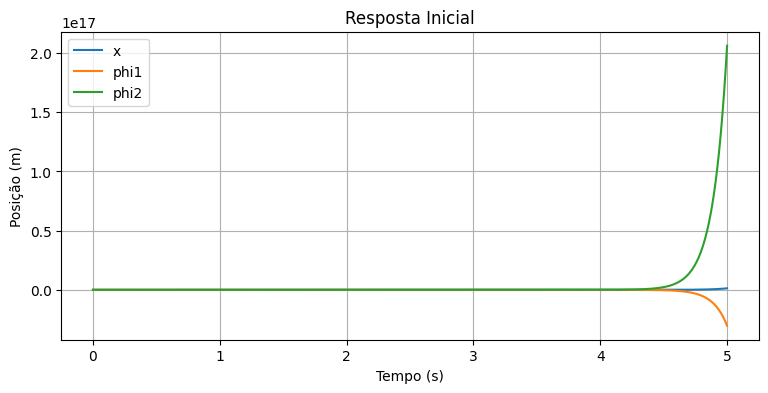

In [243]:
altura = 4
largura = 9
subplots = plt.subplots(1, 1, figsize=(largura, altura))
subplots[1].plot(t,y[0], label='x')
subplots[1].plot(t,y[1], label='phi1')
subplots[1].plot(t,y[2], label='phi2')
subplots[1].set_title('Resposta Inicial')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posição (m)')
subplots[1].grid(True)
subplots[1].legend()
plt.show()



In [247]:
ct.pzmap(sys ,plot=True)

NotImplementedError: StateSpace.zero only supports systems with the same number of inputs as outputs.